### Differential Equation

$\frac{\mathrm{d}\Psi}{\mathrm{d}x} = -(x + \frac{1 + 3x^2}{1 + x + x^3})\Psi + x^3 + 2x + x^2 \frac{1 + 3x^2}{1 + x + x^3},$

$\Psi(0) = 1, x \in [0, 2]$

In [4]:
from typing import List, Tuple, Callable
import autograd.numpy as np
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
PSI_0 = np.array([1])


def derivative(x, psi) -> np.ndarray:
    """Example #1 derivative.

    Args:
        x: The input vector
        psi: The function vector

    Returns:
        Value of psi's partial derivatives at x.
    """
    psi_dot = -(x + (1 + 3 * x**2) / (1 + x + x**3)) * psi+ x**3 + 2 * x + x**2 * (1 + 3 * x**2) / (1 + x + x**3)
    return psi_dot


def analytical_solution(x):
    """Analytical solution to example #1.
    Args:
        x: The input vector

    Returns:
        Value of psi at x.
    """
    return np.exp(-(x**2) / 2) / (1 + x + x**3) + x**2

### Activation Functions

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def arctan(z):
    return np.arctan(z)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

### Neural Network

![](NN.png "Neural Network")

In [7]:
class NeuralNetwork:
    """A neural network class for solving ODEs. Can be combine with other neural networks to solve system of ODEs.
    Attributes:
        init_condition (float): Initial condition for the target function.
        derivative (Callable): Function that calculates the target derivative of the neural network.
        input_size (int): Size of the input layer.
        hidden_sizes (np.array): Array of integers representing the sizes of the hidden layers.
        output_size (int): Size of the output layer.
        activation_fns (List[Callable]): List of activation functions for each layer.
        weights (List[np.array]): List of weights and biases for each layer.

    Methods:
        init_weights(): Initializes the weights and biases of the neural network.
        forward(t: np.array, weights: List[np.array]) -> np.array: Makes a forward pass through the neural network.
        trial_solution(t: np.array, weights: List[np.array]) -> np.ndarray: Calculates the trial solution.
        elementwise_trial_solution(t: np.array, weights: List[np.array]) -> np.ndarray: Calculates the trial solution elementwise.
        trial_grad(t: np.array, weights: List[np.array]) -> np.array: Calculates the gradient of the trial solution with respect to t.
    """

    def __init__(
        self,
        init_condition: np.array,
        derivative: Callable,
        input_size: int,
        hidden_sizes: np.array,
        output_size: int,
        activation_fns: List[Callable],
    ):
        self.init_condition = init_condition
        self.derivative = derivative
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_fns = activation_fns
        self.weights = [None] * (hidden_sizes.shape[0] + 1)  # +1 for the output
        self.init_weights()

    def init_weights(self):
        """Initializes the weights and biases of the neural network
        Args:
            None

        Returns:
            None
        """
        # hidden weights and biases
        self.weights[0] = np.random.randn(
            self.hidden_sizes[0], self.input_size + 1
        )  # +1 for the bias
        for i in range(1, self.hidden_sizes.shape[0]):
            self.weights[i] = np.random.randn(
                self.hidden_sizes[i], self.hidden_sizes[i - 1] + 1
            )  # +1 for the bias

        # output weights and biases
        self.weights[-1] = np.random.randn(
            self.output_size, self.hidden_sizes[-1] + 1
        )  # +1 for the bias

    def forward(self, t: np.array, weights: List[np.array]) -> np.array:
        """Makes a forward pass through the neural network.

        Args:
            t: The t vector
            weights: The weights and biases of the neural network

        Returns:
            A NumPy array of the output of the neural network of dim(self.output_size, len(t)).
        """
        num_layers = len(weights)
        # row matrix
        t = t.reshape(-1, t.size)

        z = None
        a = t
        for i in range(num_layers):
            z = np.matmul(weights[i], np.concatenate((np.ones((1, t.size)), a), axis=0))
            a = self.activation_fns[i](z)
        return z

    def trial_solution(self, t: np.array, weights: List[np.array]) -> np.ndarray:
        """Calculates the trial solution of the system of ODEs.

        Args:
            t: The input vector
            weights: The weights and biases of the neural network

        Returns:
            A NumPy array of the trial solution of the system of ODEs
            dimension (len(t),)
        """
        fp = self.forward(t, weights).reshape(t.size)
        return self.init_condition + t * fp

    def trial_grad(self, t: np.array, weights: List[np.array]) -> np.array:
        """Calculates the gradient of the trial solution of the Lorentz System.

        Args:
            t: The input vector
            weights: The weights and biases of the neural network

        Returns:
            A NumPy array of the gradient of the trial solution of the Lorentz System with
            dimension (len(t),)
        """
        return elementwise_grad(self.trial_solution, 0)(t, weights)

In [8]:
def mse_loss_function(
    t: np.array,
    neural_networks: List[NeuralNetwork],
    weights_list: List[List[np.array]],
) -> float:
    """Calculates the mean squared error a list of neural network.

    Args:
        t: The input vector
        neural_networks: A list of neural networks

    Returns:
        Mean squared error value
    """
    loss = 0
    trial_sol = np.array([neural_networks[i].trial_solution(t, weights_list[i]) for i in range(len(neural_networks))])

    for i in range(len(neural_networks)):
        grad_star = neural_networks[i].derivative(t, trial_sol)
        grad = neural_networks[i].trial_grad(t, weights_list[i])
        error = grad_star - grad
        loss += np.linalg.norm(error, "fro") / np.sqrt(np.size(error))

    return loss

In [9]:
def gradient_descent(t: np.array, neural_networks: List[NeuralNetwork], num_iters: int, learn_rate: float):
    """Runs gradient descent for a given number of iterations

    Args:
        t: The input vector
        num_iter: The number of iterations
        learn_rate: The learning rate

    Returns:
        neural_networks: A list of neural networks after gradient descent
    """
    loss_grad_function = grad(mse_loss_function, 2)
    loss = [0] * num_iters
    for i in range(num_iters):
        weights_list = [neural_networks[j].weights for j in range(len(neural_networks))]
        loss[i] = print_loss(t, neural_networks, weights_list, i, loss[i - 1])

        loss_grad = loss_grad_function(t, neural_networks, weights_list)
        for j in range(len(neural_networks)):
            for k in range(len(neural_networks[j].weights)):
                neural_networks[j].weights[k] = (neural_networks[j].weights[k] - learn_rate * loss_grad[j][k])

    plot_loss(num_iters, loss)

    return neural_networks


def adam(t, neural_networks, num_iters=10000, step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    loss_grad_function = grad(mse_loss_function, 2)

    m = [[np.zeros_like(neural_networks[i].weights[j]) for j in range(len(neural_networks[0].weights))]for i in range(len(neural_networks))]
    v = [[np.zeros_like(neural_networks[i].weights[j]) for j in range(len(neural_networks[0].weights))]for i in range(len(neural_networks))]

    mhat = [[None] * len(neural_networks[i].weights) for i in range(len(neural_networks))]
    vhat = [[None] * len(neural_networks[i].weights) for i in range(len(neural_networks))]

    loss = [0] * num_iters
    for i in range(num_iters):
        weights_list = [neural_networks[j].weights for j in range(len(neural_networks))]
        loss[i] = print_loss(t, neural_networks, weights_list, i, loss[i - 1])

        g = loss_grad_function(t, neural_networks, weights_list)
        for j in range(len(neural_networks)):
            for k in range(len(neural_networks[j].weights)):
                m[j][k] = (1 - b1) * g[j][k] + b1 * m[j][k]  # First  moment estimate.
                v[j][k] = (1 - b2) * (g[j][k] ** 2) + b2 * v[j][k]  # Second moment estimate.
                mhat[j][k] = m[j][k] / (1 - b1 ** (i + 1))  # Bias correction.
                vhat[j][k] = v[j][k] / (1 - b2 ** (i + 1))
                neural_networks[j].weights[k] = neural_networks[j].weights[k] - step_size * mhat[j][k] / (np.sqrt(vhat[j][k]) + eps)

    plot_loss(num_iters, loss)

    return neural_networks


def print_loss(t: np.array, neural_networks: List[NeuralNetwork], weights_list: List[List[np.array]], iter: int, prev_loss: float):
    """Prints the iteration number and loss of the neural networks.

    Args:
        t: The input vector
        neural_networks: A list of neural networks
        weights_list: The weights and biases of the neural networks

    Returns:
        loss: The loss of the neural networks
    """
    loss = mse_loss_function(t, neural_networks, weights_list)
    print("\033[0m", end="")
    print("Iteration: ", iter)
    if loss < prev_loss:
        print("\033[38;5;121m", loss)
    else:
        print("\033[38;5;210m", loss)

    return loss


def plot_loss(num_iter, loss):
    """Plots the loss of the neural networks.

    Args:
        num_iter: The number of iterations
        loss: np.array of the loss at each iteration

    Returns:
        None
    """
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    sns.set_theme(style="darkgrid", palette="muted", font="DeJavu Serif")
    ax.plot(np.arange(0, num_iter), loss, lw=1)
    sns.despine()

### Training

Iteration:  0
 14.45481499978339
Iteration:  1
 14.085014514739045
Iteration:  2
 13.717348647709072
Iteration:  3
 13.351894442034615
Iteration:  4
 12.988724796403101
Iteration:  5
 12.62790749619035
Iteration:  6
 12.26950397651447
Iteration:  7
 11.913567770561851
Iteration:  8
 11.56014262846573
Iteration:  9
 11.209260369067122
Iteration:  10
 10.860938678511173
Iteration:  11
 10.515179323964533
Iteration:  12
 10.171967603146598
Iteration:  13
 9.831274180531414
Iteration:  14
 9.493060421968735
Iteration:  15
 9.157287491817797
Iteration:  16
 8.82392798310111
Iteration:  17
 8.492977846966557
Iteration:  18
 8.16446676699473
Iteration:  19
 7.838466434032357
Iteration:  20
 7.515097377922583
Iteration:  21
 7.19453557201639
Iteration:  22
 6.877020166924736
Iteration:  23
 6.562863724939242
Iteration:  24
 6.252466123493982
Iteration:  25
 5.946332950279532
Iteration:  26
 5.645099011092884
Iteration:  27
 5.349557502971868
Iteration:  28
 5.060695187157684
Iteration:  29
 4.

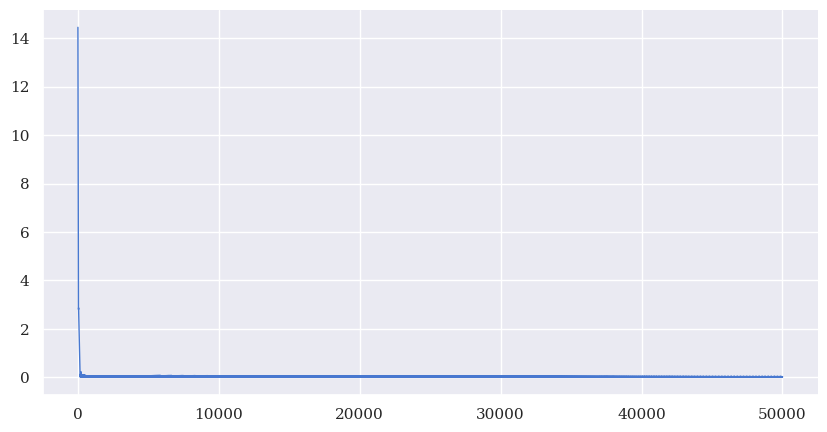

In [12]:
def train(init_conditions):
    t = np.arange(0, 2, 0.2)
    hidden_sizes = np.array([10])
    activation_fns = [sigmoid] * (len(hidden_sizes)) + [lambda x: x]
    nn = NeuralNetwork(init_conditions[0], derivative, 1, hidden_sizes, 1, activation_fns)
    adam(t, [nn], num_iters=50000, step_size=0.01)
    # gradient_descent(t, [nn1, nn2], num_iters=10000, learn_rate=0.001)

    return nn

nn = train(PSI_0)

### Evaluating Results

In [17]:
def plot_ode(neural_network: NeuralNetwork, scale=1, dt=0.1):
   t = np.arange(0, 2, dt)
   res = neural_network.trial_solution(t, neural_network.weights)
   fig = plt.figure(figsize=(5, 5))
   ax = fig.add_subplot()
   ax.plot(t, res, lw=1)
   ax.plot(t, analytical_solution(t), lw=1)
   plt.legend(["nn", "analytical"])

   print(analytical_solution(t) - res[0])


def plot_system_ode(neural_networks: List[NeuralNetwork], scale=1, dt=0.3):
   t = np.arange(0, 3, dt)
   res = [neural_networks[i].trial_solution(t, neural_networks[i].weights) for i in range(len(neural_networks))]
   fig = plt.figure(figsize=(5, 5))
   ax = fig.add_subplot()
   ax.plot(res[0], res[1], lw=1)
   ax.plot(analytical_solution(t)[0], analytical_solution(t)[1], lw=1)
   plt.legend(["nn", "analytical"])


def simulate_sode(t, initial_conditions, derivative) -> Tuple[np.ndarray, np.ndarray]:
   """Simulate the system of ODEs over the time interval [0, dt * num_steps].

   Args:
      dt: The t step
      initial_conditions: The initial conditions
      num_steps: The number of t steps to calculate

   Returns:
      A tuple of two NumPy arrays: the function output values, and the derivatives.
   """
   df_dt = np.empty((len(t), len(initial_conditions)))
   output = np.empty((len(t), len(initial_conditions)))
   output[0] = initial_conditions

   for i in range(len(t) - 1):
      dt = t[i + 1] - t[i]
      output[i + 1] = output[i] + derivative(t[i], output[i]) * dt
      df_dt[i] = derivative(t[i], output[i])

   return output, df_dt

[ 0.         -0.18957989 -0.18004944  0.06369981  0.5639186   1.30525999
  2.26292617  3.41891922  4.7632591   6.29111711]


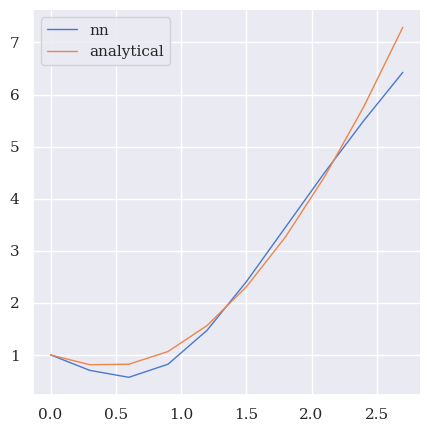

In [18]:
sns.set_theme(style="darkgrid", palette="muted", font="DeJavu Serif")
plot_ode(nn)
sns.despine()